#### Eden Shmuel 209348697
#### Shahar Turgeman 316223304

### Necessary imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import requests
import json
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler 
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn import svm
from scipy import stats
from scipy.stats.mstats import winsorize
from category_encoders import TargetEncoder

### Dataset Reading and Preparation:

In [2]:
temp_train_set = pd.read_csv('')
temp_test_set = pd.read_csv('')

In [5]:
def prepare_data(dataframe):
    
    # Drop Duplicate Rows
    dataframe.drop_duplicates(keep='first', inplace=True)
    
    # Dropping Irrelevant Columns
#1. The Area column was dropped because it contains redundant information with the City column. Since both columns provide location information, keeping both would not add additional value to the analysis or modeling process.
#2. The pic num, cre date and repub date columns were dropped because they are not expected to significantly influence the vehicle price prediction model. The number of pictures associated with a listing is not directly related to the price of a vehicle.
   #The creation and republication dates of a listing are typically administrative details and are unlikely to affect the price of a vehicle.By removing these columns, we streamline the dataset and focus on features more directly related to predicting vehicle prices.
#3. The Test column was dropped due to high percentage of missing values (approximately 2/3 of the data) and limited potential impact on predicting vehicle prices.
   #Instead of imputing missing values with arbitrary or derived values, which could introduce bias, we opted to remove this column entirely to maintain data integrity and model accuracy.

    columns_to_drop = ['Area', 'Pic_num', 'Cre_date', 'Repub_date', 'Test']
    dataframe.drop(columns=columns_to_drop, inplace=True)
    
    # Cleaning and Standardizing Model Names
    # Removes redundant manufacturer names and standardizes model names.
    def clean_model_column(row):
        manufactor = row['manufactor']
        model = row['model']
        model = re.sub(r'\b' + re.escape(manufactor) + r'\b', '', model, flags=re.IGNORECASE)
        model = re.sub(r'\(\d{4}\)', '', model)
        model = re.sub(r'\b\d{4}\b', '', model)
        model = re.sub(r',', '', model)
        return model.strip()
    dataframe.loc[:,'model']= dataframe.apply(clean_model_column, axis=1)
    
    # Additional Model Cleaning
    # Further cleaning model names and removing unwanted characters.
    dataframe['model'] = dataframe['model'].str.replace('לקסוס', '', regex=False).str.strip()
    dataframe.loc[:, 'capacity_Engine'] = dataframe['capacity_Engine'].str.replace(',', '', regex=True)
    dataframe.loc[:, 'Km'] = dataframe['Km'].str.replace(',', '', regex=True)
    
    # Normalizing Values
    # Standardizes various categorical values for consistency.
    replacements = {
        'manufactor': {'Lexsus': 'לקסוס'},
        'Engine_type': {'היברידי': 'היבריד'},
        'Gear': {'אוטומט': 'אוטומטית'},
        'model': {
            'סיוויק הייבריד': 'סיוויק',
            'סוויפט החדשה': 'סויפט',
            'CIVIC': 'סיוויק',
            'ACCORD': 'אקורד',
            'פלואנס חשמלי': 'פלואנס'
        },
        'City': {
            'Tel aviv': 'תל אביב',
            'Rishon LeTsiyon': 'ראשון לציון',
            'Tzur Natan': 'צור נתן',
            'jeruslem': 'ירושלים',
            'Rehovot': 'רחובות',
            'ashdod': 'אשדוד'
        }
    }
    for column, replace_dict in replacements.items():
        dataframe[column] = dataframe[column].replace(replace_dict)
    
    #Replace "לא מוגדר" with NaN 
    dataframe.replace('לא מוגדר', np.nan, inplace=True)
    
    # Handling Electric Vehicles
    # Setting engine capacity to 0 for electric vehicles as they do not have traditional engines.
    dataframe.loc[dataframe['Engine_type'] == 'חשמלי', 'capacity_Engine'] = 0
    
    # Filling Missing Values with Mode
    # Fills missing values based on mode of each group for categorical columns.
    def fill_missing_with_mode(df, columns):
        df[columns] = df[columns].replace('None', pd.NA)
        # Define a fallback function to get the mode or the second mode if the first is NaN
        def mode_fallback(series):
            modes = series.mode()
            if len(modes) == 0:
                return np.nan
            elif pd.isna(modes[0]):
                return modes[1] if len(modes) > 1 else np.nan
            return modes[0]
        
        for col in columns:
            df[col] = df[col].fillna(df.groupby(['manufactor', 'model'])[col].transform(mode_fallback))
            
        # Define a fallback function to get the mode of the 'manufactor' group if all values are NaN       
        def manufactor_mode_fallback(series):
            modes = series.mode()
            if len(modes) == 0:
                return np.nan
            return modes[0]
    
        for col in columns:
            df[col] = df[col].fillna(df.groupby('manufactor')[col].transform(manufactor_mode_fallback))
            
         # Fill missing values based on overall mode of the column
        for col in columns:
            overall_mode = df[col].mode()[0]
            df[col] = df[col].fillna(overall_mode)
            
        return df
       
    # Specify columns to fill missing values
    columns_to_fill = ['Gear', 'Engine_type', 'Prev_ownership', 'Curr_ownership', 'capacity_Engine', 'Color']
    dataframe = fill_missing_with_mode(dataframe, columns_to_fill)
    
    # Filling Missing 'Km' with Median
    # Uses overall and group-specific medians to fill missing 'Km' values.
    def fill_missing_with_median(df):
        df['Km'] = df['Km'].replace('None', np.nan)
        df['Km'] = pd.to_numeric(df['Km'], errors='coerce')
        overall_median = df['Km'].median()
        median_km = df.groupby(['manufactor', 'model'])['Km'].transform('median')
        df['Km'] = df['Km'].fillna(median_km)
        df['Km'].fillna(overall_median, inplace=True)
        return df
    dataframe = fill_missing_with_median(dataframe)
    
    # Fetching and Filtering API Data
    # Retrieves additional data from an external API and filters relevant entries.
    url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=5e87a7a1-2f6f-41c1-8aec-7216d52a6cf6'
    web = requests.get(url)
    dict_data = json.loads(web.text)
    
    # Extract data and create DataFrame
    api_list = []
    for number in range(0,len(dict_data["result"]["records"])):
        tozar = dict_data["result"]["records"][number]["tozar"]
        degem = dict_data["result"]["records"][number]["kinuy_mishari"]
        shnaton = dict_data["result"]["records"][number]["shnat_yitzur"]
        dictio = {'tozar':tozar,'degem':degem,'shnaton':shnaton}
        api_list.append(dictio)
    car_gov_data = pd.DataFrame(api_list)
    car_gov_data = car_gov_data.rename(columns={'tozar': 'manufactor', 'degem': 'model', 'shnaton': 'Year'})
    
    # Define the dictionary for replacement
    replace_dict = {'מזדה':'מאזדה',
                    'ב מ וו':'ב.מ.וו',
                    'וולבו':'וולוו'
    }
    # Replace the values in 'manufacturer' column
    car_gov_data['manufactor'] = car_gov_data['manufactor'].replace(replace_dict)
    
    # Filter relevant manufacturers
    to_keep = ['סובארו', 'הונדה', 'יונדאי', "פיג'ו", 'רנו', 'סקודה', 'קיה',
               'אופל', 'פולקסווגן', 'מיצובישי', 'פורד', 'מאזדה', 'סיטרואן',
               'ניסאן', 'אאודי', 'טויוטה', 'ב.מ.וו', 'סוזוקי', 'שברולט', 'מרצדס',
               'לקסוס', 'דייהטסו', 'מיני', 'קרייזלר', 'אלפא רומיאו', 'וולוו']
    # Filter the DataFrame
    filtered_api_data = car_gov_data[car_gov_data['manufactor'].isin(to_keep)]
    
    # Replacing Model Names
    # Matches and replaces model names from the external API data.
    def replace_model_name(df, filtered_api_data):
        manufacturers = df['manufactor'].unique()
        for manufacturer in manufacturers:
            model_api = filtered_api_data[filtered_api_data['manufactor'] == manufacturer]
            model_df = df[df['manufactor'] == manufacturer]
        
            # Create a dictionary of current model names and their replacements
            model_replacements = {df_model: api_model for df_model in model_df['model'].unique() 
                              for api_model in model_api['model'].unique()
                              if df_model.lower() == api_model.lower()}
            df.loc[df['manufactor'] == manufacturer, 'model'] = \
                df[df['manufactor'] == manufacturer]['model'].replace(model_replacements)
    
        return df
    dataframe = replace_model_name(dataframe, filtered_api_data)
    
    # Calculating Supply Score
    # Computes the supply score based on the frequency of similar rows in API data.
    def supply_score(df, model_api):
        similar_rows_count = model_api.groupby(['manufactor', 'model', 'Year']).size().reset_index(name='supply')
        count_dict = {(row['manufactor'], row['Year'], row['model']): row['supply'] for idx, row in similar_rows_count.iterrows()}
        def get_supply(row):
            return count_dict.get((row['manufactor'], row['Year'], row['model']), 0)
        df['Supply_score'] = df.apply(get_supply, axis=1)
    supply_score(dataframe, filtered_api_data)
    
    # Creating 'No_accident' Column
    # Identifies and flags records indicating no accidents in the description.
    pattern = r'(שמור(?:ה)?|בלי תאונות|ללא תאונות|לא תאונות|לא עברה תאונות|לא עבר תאונות|שמיר)'
    def check_keyword_in_description(description):
        return 1 if re.search(pattern, description) else 0
    dataframe['No_accident'] = dataframe['Description'].apply(lambda x: check_keyword_in_description(str(x)))
    dataframe.drop(columns=['Description'], inplace=True)
    
    # Converting Data Types
    # Ensures proper data types for each column to facilitate analysis and modeling.
    dataframe['Year'] = dataframe['Year'].astype(int)
    dataframe['Hand'] = dataframe['Hand'].astype(int)
    dataframe['Gear'] = dataframe['Gear'].astype('category')
    dataframe['capacity_Engine'] = dataframe['capacity_Engine'].astype(int)
    dataframe['Engine_type'] = dataframe['Engine_type'].astype('category')
    dataframe['Prev_ownership'] = dataframe['Prev_ownership'].astype('category')
    dataframe['Curr_ownership'] = dataframe['Curr_ownership'].astype('category')
    dataframe['City'] = dataframe['City'].astype('string')
    dataframe['Price'] = dataframe['Price'].astype(float)
    dataframe['Color'] = dataframe['Color'].astype('string')
    dataframe['Km'] = dataframe['Km'].astype(int)
    dataframe['Supply_score'] = dataframe['Supply_score'].astype(int)
    dataframe['No_accident'] = dataframe['No_accident'].astype(bool)
    
    # Winsorize the data for 'capacity_Engine', 'Km', 'Hand'
    columns_to_winsorize = ['capacity_Engine', 'Km', 'Hand', 'Year']
    for col in columns_to_winsorize:
        dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.05])
    
    # Remove outliers using z-score method
    def remove_outliers_zscore(df, columns, threshold=3):
        z_scores = np.abs(stats.zscore(df[columns]))
        filtered_entries = (z_scores < threshold).all(axis=1)
        return df[filtered_entries]
    dataframe = remove_outliers_zscore(dataframe, columns_to_winsorize)
    
    # Remove outliers using IQR method
    def remove_outliers_iqr(df, columns):
        Q1 = df[columns].quantile(0.25)
        Q3 = df[columns].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_entries = ((df[columns] >= lower_bound) & (df[columns] <= upper_bound)).all(axis=1)
        return df[filtered_entries]
    dataframe = remove_outliers_iqr(dataframe, columns_to_winsorize)
    
    # One-hot encode remaining categorical features
    categorical_features = ['manufactor', 'model', 'City', 'Color', 'Gear', 'Engine_type', 'Prev_ownership', 'Curr_ownership', 'No_accident']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder.fit_transform(dataframe[categorical_features])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
    dataframe = dataframe.drop(categorical_features, axis=1).reset_index(drop=True)
    dataframe = pd.concat([dataframe, encoded_df], axis=1)
    
    # Scale numerical features
    numerical_features = ['Year', 'Hand', 'capacity_Engine', 'Km', 'Supply_score']
    scaler = RobustScaler()
    scaler.fit(dataframe[numerical_features])
    dataframe[numerical_features] = scaler.transform(dataframe[numerical_features])
    
    
    return dataframe

In [6]:
train_set = prepare_data(temp_train_set)

In [7]:
test_set = prepare_data(temp_test_set)

In [8]:
# Split data into features and target
X_train = train_set.drop(columns=['Price'])
y_train = train_set['Price']
X_test = test_set.drop(columns=['Price'])
y_test = test_set['Price']

### Evaluating Model Performance with Cross-Validation

In [9]:
# Initialize the ElasticNet model
model = ElasticNet(alpha=0.1, l1_ratio=0.9)

# Function to calculate Root Mean Squared Error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define the cross-validation procedure (KFold with 10 splits)
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# Evaluate using RMSE as scoring method
scoring_rmse = make_scorer(rmse, greater_is_better=False)
cv_scores_rmse = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring_rmse)
cv_scores_rmse = np.abs(cv_scores_rmse)

# Evaluate using Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

scoring_mae = make_scorer(mae, greater_is_better=False)
cv_scores_mae = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring_mae)
cv_scores_mae = np.abs(cv_scores_mae)

# Evaluate using R² score (Coefficient of Determination)
from sklearn.metrics import r2_score
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

scoring_r2 = make_scorer(r2)
cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring_r2)

# Evaluate using Explained Variance score
from sklearn.metrics import explained_variance_score
def explained_variance(y_true, y_pred):
    return explained_variance_score(y_true, y_pred)

scoring_ev = make_scorer(explained_variance)
cv_scores_ev = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring_ev)

# Print the results for each metric
print("Cross-validation RMSE scores: ", cv_scores_rmse)
print("Mean RMSE: ", cv_scores_rmse.mean())

print("Cross-validation MAE scores: ", cv_scores_mae)
print("Mean MAE: ", cv_scores_mae.mean())

print("Cross-validation R² scores: ", cv_scores_r2)
print("Mean R²: ", cv_scores_r2.mean())

print("Cross-validation Explained Variance scores: ", cv_scores_ev)
print("Mean Explained Variance: ", cv_scores_ev.mean())

#Train the Model
model.fit(X_train, y_train)

Cross-validation RMSE scores:  [ 9988.52991281 12282.87197393 10370.29922586 12762.49546046
 12233.46724602 15894.24452953  9430.26923408 15828.69733408
 11936.25183478 12851.70874809]
Mean RMSE:  12357.883549963737
Cross-validation MAE scores:  [ 7821.23320946  9329.04112804  8582.82135543  9226.92948574
  9171.60467644 10969.36630007  7542.97671904 11131.48126167
  9329.68434301  9430.71889476]
Mean MAE:  9253.585737367139
Cross-validation R² scores:  [0.7693601  0.67227235 0.74574429 0.69136924 0.68257805 0.57569632
 0.80698    0.55699961 0.66428706 0.65355112]
Mean R²:  0.6818838135985936
Cross-validation Explained Variance scores:  [0.76986063 0.67902156 0.75618228 0.69257379 0.6843855  0.57723383
 0.80698029 0.55777188 0.66442102 0.65880045]
Mean Explained Variance:  0.6847231231855828


ElasticNet(alpha=0.1, l1_ratio=0.9)

### Top Five Features Impacting Car Price Prediction

Top 5 features with the greatest impact on the prediction:
Year                20192.642937
manufactor_אאודי     9456.805669
City_ירכא            9186.523918
model_אאוטלנדר       8739.161931
manufactor_פורד      8540.997943
dtype: float64


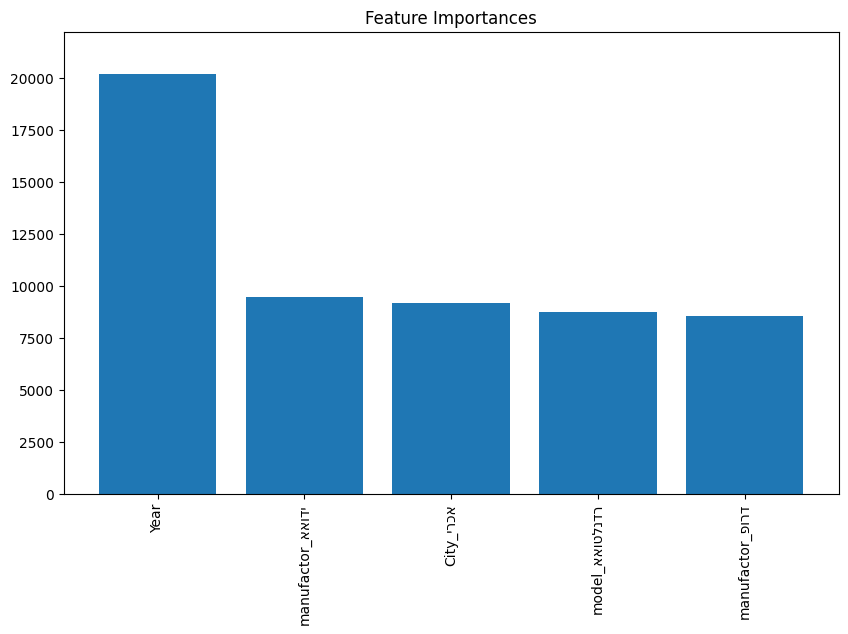

In [21]:
# Get feature importance using model coefficients
feature_importance = pd.Series(model.coef_, index=X_train.columns)

# Identify the top 5 features with the greatest impact on the prediction
top_5_features = feature_importance.abs().nlargest(5)
print("Top 5 features with the greatest impact on the prediction:")
print(top_5_features)

# Plotting the feature importances
def plot_feature_importance(importances, ax=None, feats_to_highlight=None):
    indices = np.argsort(importances)[::-1]

    if ax is None:
        fig, ax = plt.subplots()

    rects = ax.bar(range(len(importances)), importances[indices], tick_label=importances.index[indices], align="center")
    ax.set_title("Feature Importances")
    ax.set_ylim((0, max(importances) * 1.1))

    if feats_to_highlight is not None:
        highlight = [feat in feats_to_highlight for feat in importances.index[indices]]
        rects2 = ax.bar(range(len(importances)), importances[indices] * highlight, tick_label=importances.index[indices], color='r', align="center")

    plt.xticks(rotation=90)
    return rects

fig, ax = plt.subplots(figsize=(10, 6))
plot_feature_importance(top_5_features, ax=ax)
plt.show()